In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import torch
import torch.nn as nn
from torchvision import transforms,datasets
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix

plt.style.use('fivethirtyeight')

In [3]:
#Loading the data

ROOT_DIR = 'MNIST'

#Training Data
train_data = datasets.MNIST(
    root = ROOT_DIR,
    train = True,
    transform = transforms.ToTensor(),
    target_transform = None,
    download = True
)

#Testing Data
test_data = datasets.MNIST(
    root = ROOT_DIR,
    train=False,
    transform = transforms.ToTensor(),
    target_transform = None,
    download = True
)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting MNIST/MNIST/raw/train-images-idx3-ubyte.gz to MNIST/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to MNIST/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST/MNIST/raw



In [4]:
train_data.data.dtype

torch.uint8

In [5]:
train_data.data[0]

tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,  18,
          18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   

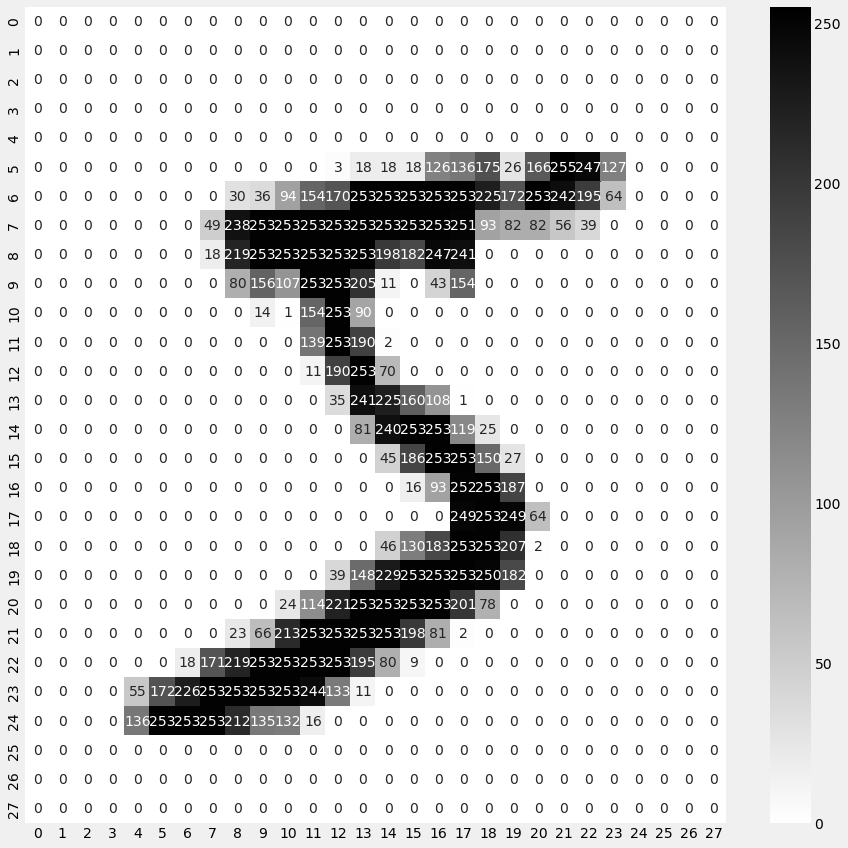

In [6]:
plt.figure(figsize = (14,14))
sns.heatmap(train_data.data[0], annot = True,cmap = 'binary',fmt='d')

In [7]:
train_data.data[0].shape

torch.Size([28, 28])

In [8]:
train_data.data[0].min().numpy(),train_data.data[0].max().numpy()

(array(0, dtype=uint8), array(255, dtype=uint8))

In [9]:
train_data.targets

tensor([5, 0, 4,  ..., 5, 6, 8])

In [10]:
train_data.targets.dtype

torch.int64

In [11]:
train_data.data.shape

torch.Size([60000, 28, 28])

In [12]:
test_data.data.shape

torch.Size([10000, 28, 28])

In [13]:
BATCH = 128

train_data_loader = DataLoader(dataset=train_data,
                               batch_size = BATCH,
                               shuffle = True)

test_data_loader = DataLoader(dataset = test_data,
                              batch_size = BATCH)



In [14]:
for image in test_data_loader:
  print(image[0].shape)
  print(image[1].shape)
  break

torch.Size([128, 1, 28, 28])
torch.Size([128])


In [15]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [16]:
from re import M
#Define the Model

class NeuralNetwork(nn.Module):
  def __init__(self,in_,out_):
    super(NeuralNetwork,self).__init__()
    self.layers = nn.Sequential(
        nn.Linear(in_,256),
        nn.ReLU(),
        nn.Linear(256,128),
        nn.ReLU(),
        nn.Linear(128,out_)
    )
  
  def forward(self,x):
    return self.layers(x)

In [17]:
modelNN = NeuralNetwork(784,10)
modelNN.to(device)
modelNN

NeuralNetwork(
  (layers): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=10, bias=True)
  )
)

In [18]:
modelNN.parameters()

<generator object Module.parameters at 0x7f1fe5a8d7d0>

In [19]:
modelNN.get_parameter

<bound method Module.get_parameter of NeuralNetwork(
  (layers): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=10, bias=True)
  )
)>

In [20]:
#Using Cross Entropy Loss and Adam Optimizer

CrossEntropyLoss = nn.CrossEntropyLoss()
Optimizer = torch.optim.Adam(modelNN.parameters())

In [21]:
# Training Loop
EPOCH = 10
loss_ = list()
acc_ = list()

for epoch in range(EPOCH):
  print(f"Epoch: {epoch+1}/{EPOCH}")
  for batch,data in enumerate(train_data_loader):
    x = data[0].to(device)
    y = data[1].to(device)
    Optimizer.zero_grad()
    y_prediction = modelNN(x.reshape(-1,784))
    loss = CrossEntropyLoss(y_prediction,y)
    loss_.append(loss.item())
    loss.backward()
    Optimizer.step()


    # Calculating accuracy
    accuracy = torch.mean((torch.argmax(y_prediction,1) == y).float()).item()
    acc_.append(accuracy)

    if batch % 100 == 0:
      print(f" Batch : {batch},Loss : {loss.item():.4f} Accuracy {accuracy:.4f}")


Epoch: 1/10
 Batch : 0,Loss : 2.3182 Accuracy 0.0625
 Batch : 100,Loss : 0.2950 Accuracy 0.9062
 Batch : 200,Loss : 0.2212 Accuracy 0.9141
 Batch : 300,Loss : 0.1724 Accuracy 0.9453
 Batch : 400,Loss : 0.2624 Accuracy 0.8984
Epoch: 2/10
 Batch : 0,Loss : 0.1190 Accuracy 0.9609
 Batch : 100,Loss : 0.0985 Accuracy 0.9688
 Batch : 200,Loss : 0.1191 Accuracy 0.9453
 Batch : 300,Loss : 0.1011 Accuracy 0.9609
 Batch : 400,Loss : 0.1449 Accuracy 0.9453
Epoch: 3/10
 Batch : 0,Loss : 0.1075 Accuracy 0.9688
 Batch : 100,Loss : 0.1164 Accuracy 0.9609
 Batch : 200,Loss : 0.1273 Accuracy 0.9688
 Batch : 300,Loss : 0.0837 Accuracy 0.9766
 Batch : 400,Loss : 0.0330 Accuracy 0.9844
Epoch: 4/10
 Batch : 0,Loss : 0.0570 Accuracy 0.9844
 Batch : 100,Loss : 0.0123 Accuracy 1.0000
 Batch : 200,Loss : 0.0398 Accuracy 0.9922
 Batch : 300,Loss : 0.0555 Accuracy 0.9844
 Batch : 400,Loss : 0.0695 Accuracy 0.9766
Epoch: 5/10
 Batch : 0,Loss : 0.0533 Accuracy 0.9922
 Batch : 100,Loss : 0.0166 Accuracy 0.9922
 Bat

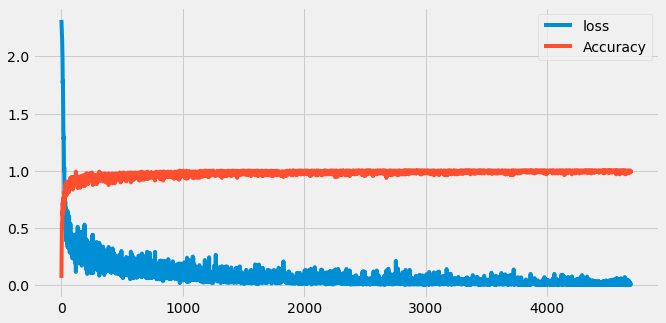

In [23]:
pd.DataFrame(data={'loss':loss_,"Accuracy":acc_}).plot(figsize=(10,5))

In [24]:
#Testing the Test Data

test_loss = 0
test_acc = 0

#Context-manager that disabled gradient calculation
# Disabling gradient calculation is useful for inference when you are sure that you will not call Tensor.backward()

with torch.no_grad():
  for batch,data in enumerate(test_data_loader):
    x = data[0].to(device)
    y = data[1].to(device)

    y_prediction = modelNN(x.reshape(-1,784))
    loss = CrossEntropyLoss(y_prediction,y)

    test_loss += loss.item()
    test_acc += torch.mean((torch.argmax(y_prediction,1)==y).float()).item()
    batch +=1

In [25]:
print(f"Test Loss: {test_loss/batch:.4f},Test accuracy:{test_acc/batch:.4f}")

Test Loss: 0.0912,Test accuracy:0.9757


In [26]:
prediction = np.array([])
target = np.array([])

with torch.no_grad():
  for batch , data in enumerate(test_data_loader):
    x = data[0].to(device)
    y = data[1].to(device)

    y_prediction = modelNN(x.reshape(-1,784))
    loss = CrossEntropyLoss(y_prediction,y)
    
    prediction  = np.concatenate((prediction,torch.argmax(y_prediction,1).cpu().numpy()))
    target = np.concatenate((target,y.cpu().numpy()))


In [27]:
prediction

array([7., 2., 1., ..., 4., 5., 6.])

In [28]:
cm = confusion_matrix(target,prediction)

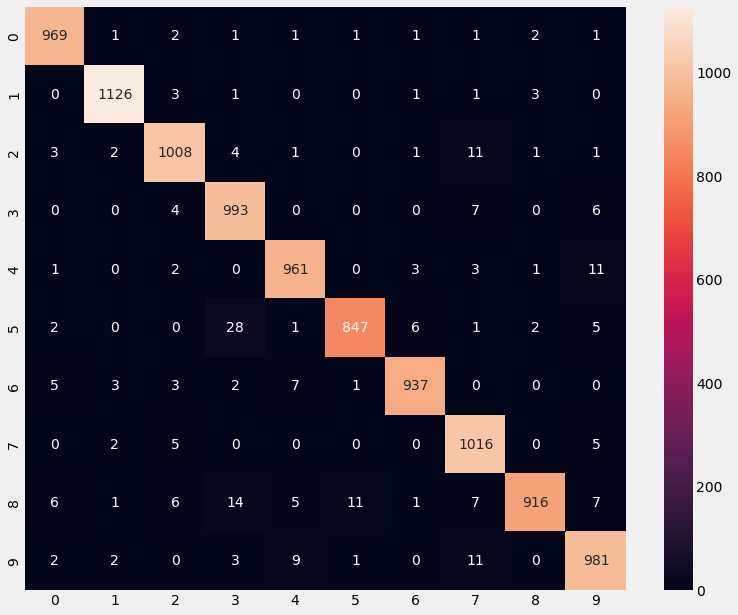

In [29]:
plt.figure(figsize = (12,10))
sns.heatmap(cm,annot = True,fmt='d')